# Machine Learning Portfolio
### Henri-Louis Boisvert H00381701

#### https://www.kaggle.com/andrewmvd/animal-faces

This dataset consists of 16130 images in 3 classes.

### Reasons for the choice of the dataset:
- An image dataset will teach me about the basics of image processing and will be very appropriate for convolutional neural networks at the end of the semester.
- This dataset consists of high definition (512*512) images that can be reduced if necessary, there are no error or issue with the data and there is a large number of images (16130 images in 3 classes).
- 3 classes are more interesting than 2 but it's not too overwhelming or ressource intensive and there is still a good number of images for each class.

### Visualization:
- printing a few random images from each class to get a general idea about the data
- printing the shapes and the number of image per class

### Preprocessing and normalization:
- checking for errors when loading the images
- converting the images into 3D arrays [color channel][height][width] with numpy.array()
- downscale the images arrays to a smaller resolution
- convert into 2D greyscale arrays by multiplying the RGB values by coefficients : I get 3D arrays [height][width]
- normalizing by dividing all values by 255 to get values between 0 and 1
- convert the 2D greyscale arrays into 1D arrays
- Put all the 1D arrays into a .csv file with each pixel as a column and each pixel as a row

### Naive Bayesian classification:
- Create training and testing datasets
- Apply multinomial, binomial and gaussian classifiers

### General feature correlation:
- Apply an absolute Pearson correlation on the whole dataset
- Plot the correlation values of each pixel as an image to understand which pixels are most relevant

### Run again a naive bayesian classifier on a smaller dataset of the most relevant features:
- Create a smaller dataset containing only the pixel with the higher general correlation values
- Apply multinomial, binomial and gaussian classifiers on this dataset
- Doing this results in a large drop in accuracy, with the 5 most relevant features there's a 20% drop in accuracy, and depending on the classifier almost all the images from a class can be entirely classified as a different class.


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from skimage import filters, transform, color
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import KFold, cross_validate, cross_val_predict, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from numpy import mean
from numpy import std
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [49]:
mainFolder = 'Cat_Dog_or_Wild'
directory = os.listdir(mainFolder)
smallerSize = (25,25)   # Define a smaller width,height for processing the images

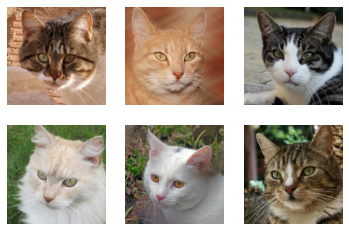

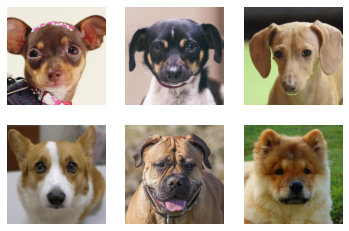

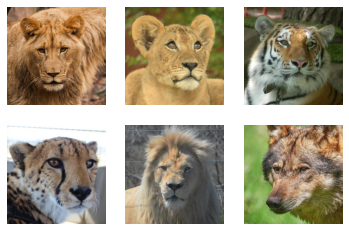

In [50]:
for each in directory:
    plt.figure()
    currentFolder = mainFolder + '/' + each
    offset = random.randint(0,len(os.listdir(currentFolder))-6)
    for i, file in enumerate(os.listdir(currentFolder)[0+offset:6+offset]):  # Go through 6 files in each sub-folder with a random offset
        fullpath = currentFolder + "/" + file
        img=plt.imread(fullpath)
        plt.subplot(2, 3, i+1)   # Plot a subplot at position i+1 on the 2*3 grid
        plt.axis('off')          # Hide axis
        plt.imshow(img)

cat: 5652 images
dog: 5238 images
wild: 5237 images


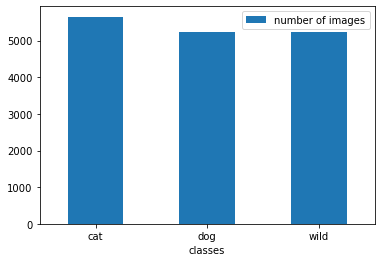

In [51]:
classes = []
lengths = []
for each in directory:
    subDir = mainFolder + '/' + each
    classes.append(each)
    lengths.append(len(os.listdir(subDir))-1)
    print(str(classes[-1]) + ': ' + str(lengths[-1]) + ' images')

df = pd.DataFrame({'classes': classes, 'number of images': lengths})
ax = df.plot.bar(x='classes', y='number of images', rot=0)


In [341]:
numberOfErrors = 0
shapes = []
for each in directory:
    currentFolder = mainFolder + '/' + each
    for file in enumerate(os.listdir(currentFolder)):  # Go through all files in each sub-folder
        try:  # Catch the errors
            im = Image.open(currentFolder +'/' + str(file[1]))
            shape = im.size
            if shape not in shapes:
                shapes.append(shape)
        except PIL.UnidentifiedImageError:
            numberOfErrors+=1

print("Number of errors: ", numberOfErrors)
print("Images shapes: ", shapes)  # width, height

Number of errors:  0
Images shapes:  [(512, 512)]


shape:  (25, 25)


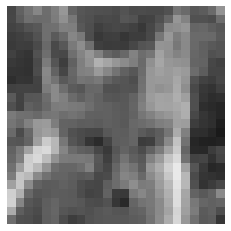

In [354]:
# Greyscaling + normalizing + rescaling on a single test image
image = Image.open(currentFolder + '/' + 'flickr_wild_000008.jpg')
arrayImage = np.array(image)
colorArrayDown = transform.resize(arrayImage,smallerSize)
greyscaleArray = np.dot(colorArrayDown, [0.2989, 0.587, 0.114])
#print("greyscaled, normalized and rescaled array: ")
#print(greyscaleArray)
greyscaleArray = greyscaleArray * 255
print("shape: ", greyscaleArray.shape) # (Width, height, number of channels = 1)
greyImage = Image.fromarray(greyscaleArray)
plt.axis('off') 
plt.imshow(greyImage)

In [343]:
# Convert all images in each class to arrays with shape (3, width, height)
imagesArrays = []
for each in directory:
    currentFolder = mainFolder + '/' + each
    for file in enumerate(os.listdir(currentFolder)):  # Go through all files in each sub-folder
        fullpath = currentFolder + "/" + str(file[1])
        imagesArrays.append(np.array(plt.imread(fullpath)))    

In [344]:
# Resize all arrays to smallerSize
for i in range(len(imagesArrays)-1):
    imagesArrays[i] = transform.resize(imagesArrays[i],smallerSize) # smallerSize = (width,height)

In [345]:
# Convert all arrays to greyscale arrays
greyscaleArrays = []
for i in range (len(imagesArrays)-1):
    greyscaleArrays.append(np.dot(imagesArrays[i], [0.2989, 0.587, 0.114])) # Values found online

In [347]:
# Convert all greyscale 2D arrays into 1D arrays
flatArrays = []
namesOfColumns = []
for i in range (smallerSize[0]**2+1):
    namesOfColumns.append(i)    # The names of the columns are the numbers between 0 and the number of pixels (+ 1 column for the class name)
flatArrays.append(namesOfColumns) # The first row becomes the name of the columns

for i in range (len(greyscaleArrays)):
    flatArray = []
    for j in range(smallerSize[0]): # The 1D arrays are created going row by row in the 2D arrays with 2 nested for loops
        for k in range(smallerSize[1]):
            flatArray.append(greyscaleArrays[i][j][k])
    if i > lengths[0] + lengths[1]: # if i > number of cat images + number of dog images
        flatArray.append(2)     # Add 2 as the class value in last column (wild animal)
    elif i > lengths[0]:        # if i > number of cat images
        flatArray.append(1)     # Add 1 as the class value in last column (dog)
    else:
        flatArray.append(0)     # Add 0 as the class value in last column (cat)
    
    flatArrays.append(flatArray)

np.savetxt("CW1.csv", flatArrays, delimiter=",") # creating a csv file: each row is a flat array made from an image

In [52]:
# Create training and testing sets from csv file
data = shuffle(pd.read_csv("CW1.csv")) # Shuffle the data from the .csv file to get all 3 classes in the train and test datasets
Xtrain = data.iloc[0:data.shape[0]-1000, 0:smallerSize[0]*smallerSize[1]]
ytrain = data.iloc[0:data.shape[0]-1000,-1]

Xtest = data.iloc[data.shape[0]-1000:data.shape[0], 0:smallerSize[0]*smallerSize[1]] # Testing set only has 1000 elements
ytest = data.iloc[data.shape[0]-1000:data.shape[0],-1]

Accuracy score:  54.900000000000006 %


<ipython-input-125-e3c9d1027723>:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-125-e3c9d1027723>:22: UserWarning:

FixedFormatter should only be used together with FixedLocator



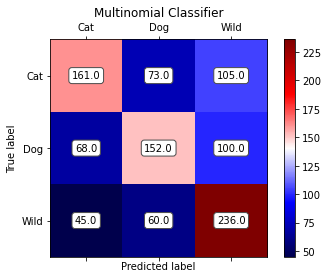

In [125]:
# Multinomial classifier
nb = MultinomialNB()
nb.fit(Xtrain, ytrain)

yPred = nb.predict(Xtest)
accScore = accuracy_score(ytest, yPred)
confMat = confusion_matrix(ytest, yPred, labels = [0, 1, 2])

print("Accuracy score: ", accScore*100,"%")

# Show the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
alpha = ['Cat', 'Dog', 'Wild']
cax = ax.matshow(confMat,cmap='seismic')
for (i, j), z in np.ndenumerate(confMat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
fig.colorbar(cax)
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
plt.title("Multinomial Classifier")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Accuracy score:  56.3 %


<ipython-input-126-f2f920835e25>:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-126-f2f920835e25>:22: UserWarning:

FixedFormatter should only be used together with FixedLocator



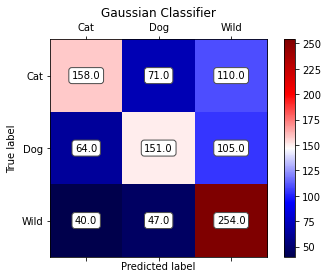

In [126]:
# Gaussian classifier
nb = GaussianNB()
nb.fit(Xtrain, ytrain)

yPred = nb.predict(Xtest)
accScore = accuracy_score(ytest, yPred)
confMat = confusion_matrix(ytest, yPred, labels = [0, 1, 2])

print("Accuracy score: ", accScore*100,"%")

# Show the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
alpha = ['Cat', 'Dog', 'Wild']
cax = ax.matshow(confMat,cmap='seismic')
for (i, j), z in np.ndenumerate(confMat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
fig.colorbar(cax)
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
plt.title("Gaussian Classifier")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Accuracy score:  52.400000000000006 %


<ipython-input-127-e4efd866a0e2>:21: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-127-e4efd866a0e2>:22: UserWarning:

FixedFormatter should only be used together with FixedLocator



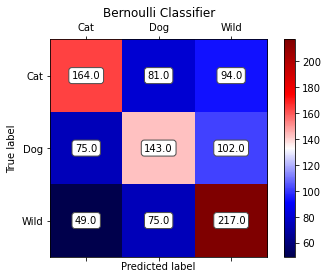

In [127]:
# Bernoulli classifier
nb = BernoulliNB(binarize = 0.5)
nb.fit(Xtrain, ytrain)

yPred = nb.predict(Xtest)
accScore = accuracy_score(ytest, yPred)
confMat = confusion_matrix(ytest, yPred, labels = [0, 1, 2])

print("Accuracy score: ", accScore*100,"%")

# Show the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
alpha = ['Cat', 'Dog', 'Wild']
cax = ax.matshow(confMat,cmap='seismic')
for (i, j), z in np.ndenumerate(confMat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
fig.colorbar(cax)
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
plt.title("Bernoulli Classifier")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [128]:
# Apply absolute Pearson correlation on all data
correlation = data.corr()
corTarget = abs(correlation.iloc[0:data.shape[0],-1]) # Get absolute value of correlation values regarding column -1 (which is the class)
corTarget = corTarget.sort_values(ascending=False)    # Sort the pixels starting with higher correlation values
correlationArray = []
correlationValues = [] # Using this to get the maximum value of correlationArray[i][1]
for i in range(1,corTarget.shape[0]): # i starts at 1 to avoid the correlation of the class with itself which is 1 (the first and maximum value of the array)
    correlationArray.append([int(float(corTarget.index[i])),float(corTarget[i])]) # correlationArray[position of pixel, correlation value of pixel]
    correlationValues.append(correlationArray[i-1][1])
maximumCorrelationValue = max(correlationValues)
for i in range(len(correlationValues)):
    correlationArray[i][1] *= 255 / maximumCorrelationValue # To have correlation values between 0 and 255 to show them as an image

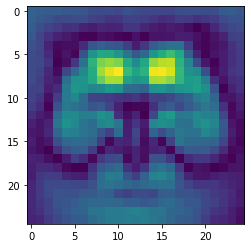

In [129]:
# Show the correlation values of each pixel as a color image
correlation1DArray = [0]*(smallerSize[0]*smallerSize[1]) # Create an empty 1D array corresponding to a 2D array
for i in range (len(correlationArray)):
    correlation1DArray[correlationArray[i][0]] = correlationArray[i][1] # correlationArray[i][0] gives the position of the pixel with the correlation value correlationArray[i][1]
correlation2DArray = np.reshape(correlation1DArray,(smallerSize[0],smallerSize[1])) # Reshape 1D array into 2D array
correlation2DArray = correlation2DArray.astype(np.uint8) # Necessary because of conversion from .csv file
correlationImage = Image.fromarray(correlation2DArray)
plt.imshow(correlationImage)

Interesting results, the background pixels have the lowest correlation values and those with the highest values are located just above the eyes, which is what we could have expected.

In [23]:
# Apply absolute Pearson correlation on the cat class
dataCat = data.iloc[0:lengths[0],0:smallerSize[0]*smallerSize[1]]
correlationMatrix = dataCat.corr()
#sns.heatmap(correlationMatrix)

In [24]:
# Apply absolute Pearson correlation on the dog class
dataDog = data.iloc[lengths[0]:lengths[0]+lengths[1]-1,0:smallerSize[0]*smallerSize[1]]
correlationMatrix = dataDog.corr()
#sns.heatmap(correlationMatrix)

In [62]:
# Apply absolute Pearson correlation on the wild class
dataWild = data.iloc[lengths[0]+lengths[1]:-1,0:smallerSize[0]*smallerSize[1]]
correlationMatrix = dataWild.corr()
#sns.heatmap(correlationMatrix)

In [25]:
nbOfMostRelevantFeatures = 4
correlatedData = data.iloc[:, [correlationArray[0][0],correlationArray[1][0],correlationArray[2][0],correlationArray[3][0],correlationArray[4][0],-1]]
XRelevantTrain = data.iloc[0:data.shape[0]-500, 0:nbOfMostRelevantFeatures]
yRelevantTrain = data.iloc[0:data.shape[0]-500,-1]

XRelevantTest = data.iloc[data.shape[0]-500:data.shape[0], 0:nbOfMostRelevantFeatures] # Testing set only has 500 elements
yRelevantTest = data.iloc[data.shape[0]-500:data.shape[0],-1]

Accuracy score:  36.4 %


<ipython-input-26-8dd5743bdb03>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-26-8dd5743bdb03>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


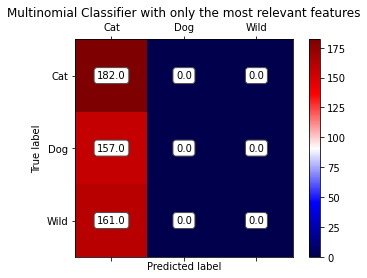

In [26]:
# Multinomial classifier
nb = MultinomialNB()
nb.fit(XRelevantTrain, yRelevantTrain)

yPred = nb.predict(XRelevantTest)
accScore = accuracy_score(yRelevantTest, yPred)
confMat = confusion_matrix(yRelevantTest, yPred, labels = [0, 1, 2])

print("Accuracy score: ", accScore*100,"%")

# Show the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
alpha = ['Cat', 'Dog', 'Wild']
cax = ax.matshow(confMat,cmap='seismic')
for (i, j), z in np.ndenumerate(confMat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
fig.colorbar(cax)
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
plt.title("Multinomial Classifier with only the most relevant features")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Accuracy score:  36.0 %


<ipython-input-27-6fdeecaf7c0e>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-27-6fdeecaf7c0e>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


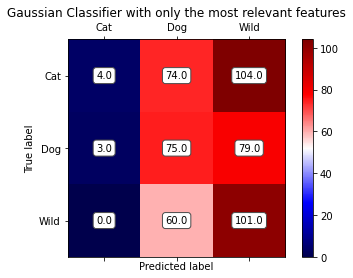

In [27]:
# Gaussian classifier
nb = GaussianNB()
nb.fit(XRelevantTrain, yRelevantTrain)

yPred = nb.predict(XRelevantTest)
accScore = accuracy_score(yRelevantTest, yPred)
confMat = confusion_matrix(yRelevantTest, yPred, labels = [0, 1, 2])

print("Accuracy score: ", accScore*100,"%")

# Show the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
alpha = ['Cat', 'Dog', 'Wild']
cax = ax.matshow(confMat,cmap='seismic')
for (i, j), z in np.ndenumerate(confMat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
fig.colorbar(cax)
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
plt.title("Gaussian Classifier with only the most relevant features")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Accuracy score:  36.4 %


<ipython-input-28-f2bc7ad6a01b>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-28-f2bc7ad6a01b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


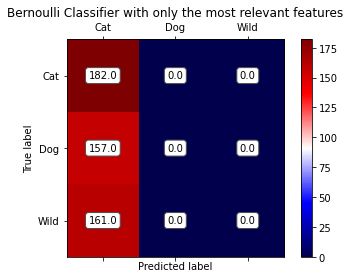

In [28]:
# Bernoulli classifier
nb = BernoulliNB()
nb.fit(XRelevantTrain, yRelevantTrain)

yPred = nb.predict(XRelevantTest)
accScore = accuracy_score(yRelevantTest, yPred)
confMat = confusion_matrix(yRelevantTest, yPred, labels = [0, 1, 2])

print("Accuracy score: ", accScore*100,"%")

# Show the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
alpha = ['Cat', 'Dog', 'Wild']
cax = ax.matshow(confMat,cmap='seismic')
for (i, j), z in np.ndenumerate(confMat):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
fig.colorbar(cax)
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
plt.title("Bernoulli Classifier with only the most relevant features")
#plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [7]:
# k-means clustering

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
yPred = kmeans.fit_predict(Xtrain)
print(yPred)
print("Inertia: ", kmeans.inertia_)

accuracy = 0
for i in range(len(yPred)):
    if yPred[i] == ytrain.iloc[i]:
        accuracy += 1

print("Accuracy: ", accuracy/len(yPred) * 100 , " %")

[2 0 1 ... 1 2 0]
Inertia:  461258.4174082742
Accuracy:  37.11415162932117  %


In [8]:
# Clusters visualization using Principal Component Analysis (PCA)

Xtrain['Cluster'] = yPred
smallerSize = 1000
plotX = pd.DataFrame(np.array(Xtrain.sample(smallerSize))) # Only take 5000 elements for easier visualization
plotX.columns = Xtrain.columns

pca_2d = PCA(n_components=2) # PCA with two principal components
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(plotX.columns[-1],axis=1))) # This DataFrame contains the two principal components that will be used for 2-D visualization

PCs_2d.columns = ["PC1_2d", "PC2_2d"]
plotX = pd.concat([plotX,PCs_2d], axis=1, join='inner')
plotX["dummy"] = 0

cluster0 = plotX[plotX['Cluster'] == 0]
cluster1 = plotX[plotX['Cluster'] == 1]
cluster2 = plotX[plotX['Cluster'] == 2]

init_notebook_mode(connected=True) # Necessary for plotting

In [9]:
# 2-D plot

trace1 = go.Scatter(     #trace1 is for 'Cluster 0'
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

trace2 = go.Scatter(     #trace2 is for 'Cluster 1'
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

trace3 = go.Scatter(     #trace3 is for 'Cluster 2'
                    x = cluster2["PC1_2d"],
                    y = cluster2["PC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 200, 0.8)'),
                    text = None)

data = [trace1, trace2, trace3]

title = "Visualizing Clusters in Two Dimensions Using PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)

The k-means clustering algorithm is barely better than classifying at random (33% accuracy), it's having trouble clustering the data (looking at the visualization, the clusters are not very "compact". The data must be too complicated to be classified this way. 

In [91]:
kmeans_iter1 = KMeans(n_clusters=3, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=3, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=3, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(Xtrain)
kmeans_iter2.fit(Xtrain)
kmeans_iter3.fit(Xtrain)
print("intertia for 1 iteration: ", kmeans_iter1.inertia_)
print("intertia for 2 iterations: ", kmeans_iter2.inertia_)
print("intertia for 3 iterations: ", kmeans_iter3.inertia_)
print("intertia by default: ", kmeans.inertia_)

# Not as good as letting the k-means algorithm choose the number of iterations

intertia for 1 iteration:  502721.5531053624
intertia for 2 iterations:  478594.76404065767
intertia for 3 iterations:  472112.0884414565
intertia by default:  460734.4575767575


In [92]:
# Changing the number of clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(Xtrain)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

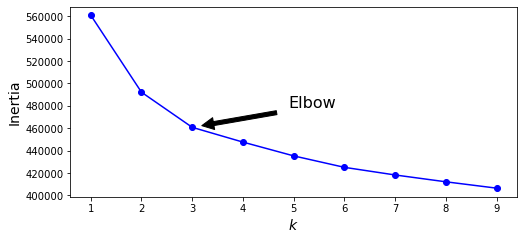

In [93]:
# Plotting the Intertia depending on the number of clusters
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

In [97]:
# Clustering using a Gaussian Mixture Model
gm = GaussianMixture(n_components=3, random_state=0).fit(Xtrain)
yPred = gm.predict(Xtrain)
accuracy = 0
for i in range(len(yPred)):
    if yPred[i] == ytrain.iloc[i]:
        accuracy += 1

print("Accuracy: ", accuracy/len(yPred) * 100 , " %")

Accuracy:  36.73739176416154  %


In [100]:
# Clustering using a hierarchical clustering method called aglomerative clustering
hc = AgglomerativeClustering().fit(Xtrain)
yPred = hc.fit_predict(Xtrain)
accuracy = 0
for i in range(len(yPred)):
    if yPred[i] == ytrain.iloc[i]:
        accuracy += 1

print("Accuracy: ", accuracy/len(yPred) * 100 , " %")

Accuracy:  35.69964967942362  %


Clustering conclusion:
- k-means, GMM and Hierarchical clustering have similar accuracies (barely better than classifying at random)
- k-means and GMM execute faster than Hierarchical clustering
- Visually (elbow method) we can see that for k-means clustering the optimal number of clusters regarding the intertia is 3
- Better to use Bayesian methods rather than clustering for classifying this dataset

Accuracy:  50.4495008990018  %


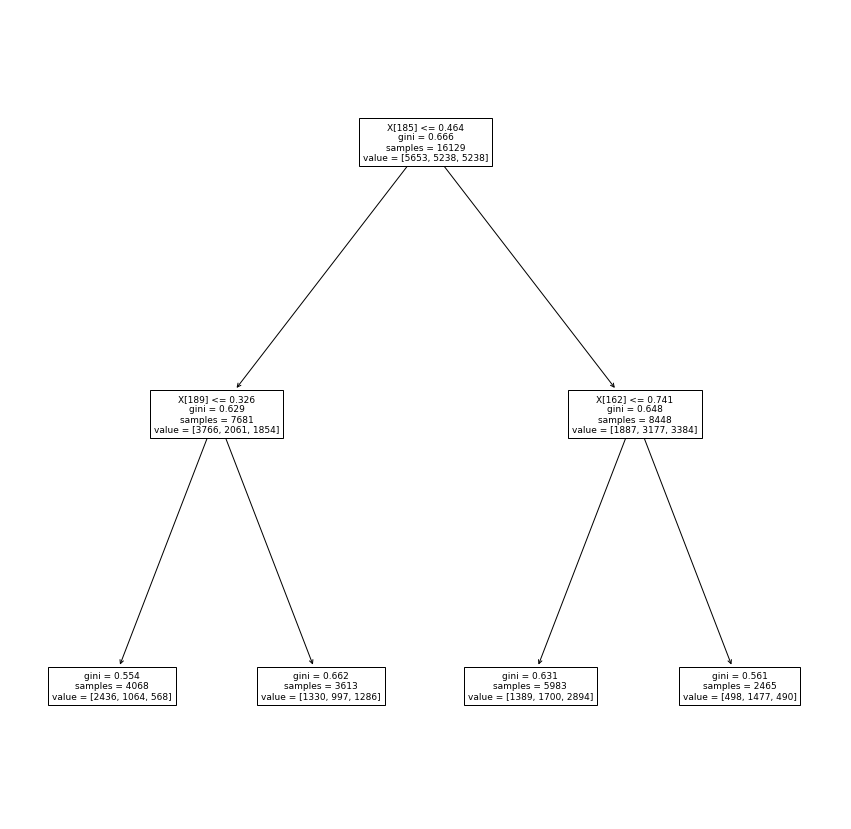

In [53]:
# Decision Trees
data = shuffle(pd.read_csv("CW1.csv"))
X = data.iloc[ : , 0:smallerSize[0]*smallerSize[1]]
y = data.iloc[ : ,-1]

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

plt.figure(figsize=(15,15))  # set plot size
plot_tree(tree_clf, fontsize=9);

# Accuracy on training set

accuracy = 0
for i in range(len(X)):
    if tree_clf.predict(X)[i] == y.iloc[i]:
        accuracy += 1
        
print("Accuracy: ", accuracy/len(y) * 100 , " %")

In [134]:
# Accuracy on training set using 10-fold cross validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
metrics = {'precision' : make_scorer(precision_score, average='macro'),
           'recall' : make_scorer(recall_score,average='macro'), 
           'f1_score' : make_scorer(f1_score,average='macro')}

scores = cross_validate(model, Xtrain, ytrain, scoring=metrics, cv=cv)
accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

In [135]:
print('Accuracy: %.6f (%.6f)' % (mean(accuracies), std(accuracies)))
print('Precision: %.6f (%.6f)' % (mean(scores['test_precision']), std(scores['test_precision'])))
print('Recall: %.6f (%.6f)' % (mean(scores['test_recall']), std(scores['test_recall'])))
print('f1 score: %.6f (%.6f)' % (mean(scores['test_f1_score']), std(scores['test_f1_score'])))

Accuracy: 0.570650 (0.006371)
Precision: 0.557899 (0.019363)
Recall: 0.557390 (0.019235)
f1 score: 0.557263 (0.019107)


Accuracy:  50.62934435468721  %


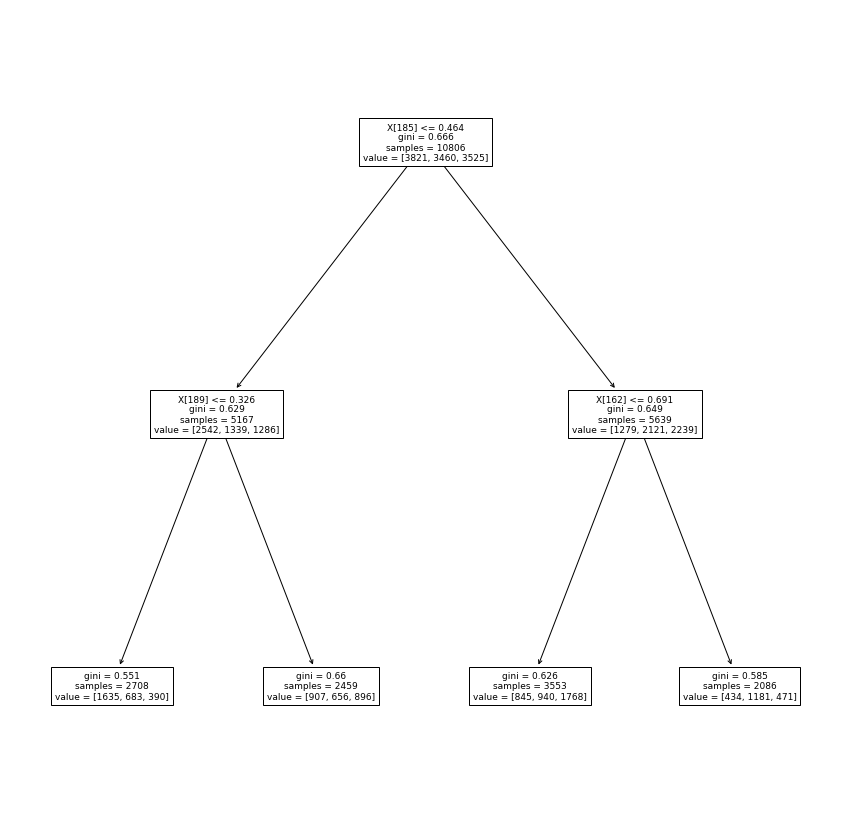

In [65]:
# Accuracy against test dataset

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(Xtrain, ytrain)

plt.figure(figsize=(15,15))  # set plot size
plot_tree(tree_clf, fontsize=9);

accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
        
print("Accuracy: ", accuracy/len(ytest) * 100 , " %")

The accuracy is almost identical whether we test on training data or on new data, the decision tree doesn't seem to have trouble generalizing to new data.

In [74]:
# Accuracy against test and train datasets changing max_depth, min_sample_leaf and splitter

tree_clf = DecisionTreeClassifier(max_depth=5, splitter='best', min_samples_split=10, random_state=42)
tree_clf.fit(Xtrain, ytrain)

accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1  
print("Accuracy against test subset (depth = 5): ", accuracy/len(ytest) * 100 , " %")

accuracy = 0
for i in range(len(Xtrain)):
    if tree_clf.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1      
print("Accuracy against train subset (depth = 5): ", accuracy/len(ytrain) * 100 , " %")

tree_clf = DecisionTreeClassifier(max_depth=20, splitter='best',min_samples_split=10, random_state=42)
tree_clf.fit(Xtrain, ytrain)

accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1  
print("Accuracy against test subset (depth = 20): ", accuracy/len(ytest) * 100 , " %")

accuracy = 0
for i in range(len(Xtrain)):
    if tree_clf.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1      
print("Accuracy against train subset (depth = 20): ", accuracy/len(ytrain) * 100 , " %")


tree_clf = DecisionTreeClassifier(max_depth=50, splitter='best',min_samples_split=10, random_state=42)
tree_clf.fit(Xtrain, ytrain)

accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1  
print("Accuracy against test subset (depth = 50): ", accuracy/len(ytest) * 100 , " %")

accuracy = 0
for i in range(len(Xtrain)):
    if tree_clf.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1      
print("Accuracy against train subset (depth = 50): ", accuracy/len(ytrain) * 100 , " %")

Accuracy against test subset (depth = 5):  57.24215667856471  %
Accuracy against train subset (depth = 5):  60.531186377938184  %
Accuracy against test subset (depth = 20):  56.22769115160624  %
Accuracy against train subset (depth = 20):  94.69739033870073  %
Accuracy against test subset (depth = 50):  56.265263948901  %
Accuracy against train subset (depth = 50):  94.95650564501203  %


In [78]:
# Accuracy against test and train datasets changing min_sample_leaf

tree_clf = DecisionTreeClassifier(max_depth=20, splitter='best', min_samples_split=2, random_state=42)
tree_clf.fit(Xtrain, ytrain)

accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1  
print("Accuracy against test subset (min samples = 2): ", accuracy/len(ytest) * 100 , " %")

accuracy = 0
for i in range(len(Xtrain)):
    if tree_clf.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1      
print("Accuracy against train subset (min samples = 2): ", accuracy/len(ytrain) * 100 , " %")

tree_clf = DecisionTreeClassifier(max_depth=20, splitter='best',min_samples_split=10, random_state=42)
tree_clf.fit(Xtrain, ytrain)

accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1  
print("Accuracy against test subset (min samples = 10): ", accuracy/len(ytest) * 100 , " %")

accuracy = 0
for i in range(len(Xtrain)):
    if tree_clf.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1      
print("Accuracy against train subset (min samples = 10): ", accuracy/len(ytrain) * 100 , " %")


tree_clf = DecisionTreeClassifier(max_depth=20, splitter='best',min_samples_split=50, random_state=42)
tree_clf.fit(Xtrain, ytrain)

accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1  
print("Accuracy against test subset (min samples = 50): ", accuracy/len(ytest) * 100 , " %")

accuracy = 0
for i in range(len(Xtrain)):
    if tree_clf.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1      
print("Accuracy against train subset (min samples = 50): ", accuracy/len(ytrain) * 100 , " %")

Accuracy against test subset (min samples = 2):  56.904001502911896  %
Accuracy against train subset (min samples = 2):  99.52803997779012  %
Accuracy against test subset (min samples = 10):  56.22769115160624  %
Accuracy against train subset (min samples = 10):  94.69739033870073  %
Accuracy against test subset (min samples = 50):  57.054292692090925  %
Accuracy against train subset (min samples = 50):  79.82602258004812  %


In [77]:
# Accuracy against test and train datasets changing splitter
tree_clf = DecisionTreeClassifier(max_depth=20, splitter='random', min_samples_split=10, random_state=42)
tree_clf.fit(Xtrain, ytrain)

accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset (splitter = random): ", accuracy/len(ytest) * 100 , " %")

accuracy = 0
for i in range(len(Xtrain)):
    if tree_clf.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset (splitter = random): ", accuracy/len(ytrain) * 100 , " %")

tree_clf = DecisionTreeClassifier(max_depth=20, splitter='best',min_samples_split=10, random_state=42)
tree_clf.fit(Xtrain, ytrain)

accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1  
print("Accuracy against test subset (splitter = best): ", accuracy/len(ytest) * 100 , " %")

accuracy = 0
for i in range(len(Xtrain)):
    if tree_clf.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1      
print("Accuracy against train subset (splitter = best): ", accuracy/len(ytrain) * 100 , " %")

Accuracy against test subset (splitter = random):  54.79992485440541  %
Accuracy against train subset (splitter = random):  91.55099019063483  %
Accuracy against test subset (splitter = best):  56.22769115160624  %
Accuracy against train subset (splitter = best):  94.69739033870073  %


In [84]:
tree_clf = DecisionTreeClassifier(max_depth=20, splitter='best', min_samples_split=2, random_state=42)
tree_clf.fit(Xtrain, ytrain)
accuracy = 0
for i in range(len(Xtest)):
    if tree_clf.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Best accuracy against test subset: ", accuracy/len(ytest) * 100 , " %")
accuracy = 0
for i in range(len(Xtrain)):
    if tree_clf.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Best accuracy against train subset: ", accuracy/len(ytrain) * 100 , " %")

Best accuracy against test subset:  56.904001502911896  %
Best accuracy against train subset:  99.52803997779012  %


In [91]:
Xtrain30, Xtest30, ytrain30, ytest30 = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)
XtestingDF = [Xtest30,Xtest]
ytestingDF = [ytest30,ytest]
Xtest30 = pd.concat(XtestingDF)
ytest30 = pd.concat(ytestingDF)

Xtrain60, Xtest60, ytrain60, ytest60 = train_test_split(Xtrain, ytrain, test_size=0.6, random_state=42)
XtestingDF = [Xtest60,Xtest]
ytestingDF = [ytest60,ytest]
Xtest60 = pd.concat(XtestingDF)
ytest60 = pd.concat(ytestingDF)

In [92]:
tree_clf = DecisionTreeClassifier(max_depth=20, splitter='best', min_samples_split=2, random_state=42)
tree_clf.fit(Xtrain30, ytrain30)
accuracy = 0
for i in range(len(Xtest30)):
    if tree_clf.predict(Xtest30)[i] == ytest30.iloc[i]:
        accuracy += 1
print("Best accuracy against test subset (30% swap): ", accuracy/len(ytest30) * 100 , " %")
accuracy = 0
for i in range(len(Xtrain30)):
    if tree_clf.predict(Xtrain30)[i] == ytrain30.iloc[i]:
        accuracy += 1
print("Best accuracy against train subset (30% swap): ", accuracy/len(ytrain30) * 100 , " %")

Best accuracy against test subset (30% swap):  54.78108581436077  %
Best accuracy against train subset (30% swap):  99.80169222633528  %


In [93]:
tree_clf = DecisionTreeClassifier(max_depth=20, splitter='best', min_samples_split=2, random_state=42)
tree_clf.fit(Xtrain60, ytrain60)
accuracy = 0
for i in range(len(Xtest60)):
    if tree_clf.predict(Xtest60)[i] == ytest60.iloc[i]:
        accuracy += 1
print("Best accuracy against test subset(60% swap): ", accuracy/len(ytest60) * 100 , " %")
accuracy = 0
for i in range(len(Xtrain60)):
    if tree_clf.predict(Xtrain60)[i] == ytrain60.iloc[i]:
        accuracy += 1
print("Best accuracy against train subset(60% swap): ", accuracy/len(ytrain60) * 100 , " %")

Best accuracy against test subset(60% swap):  53.6630812230033  %
Best accuracy against train subset(60% swap):  99.9537251272559  %


In [131]:
# Random Forest Classifier
tree_clf = RandomForestClassifier()
tree_clf.fit(Xtrain30, ytrain30)
accuracy = 0
for i in range(len(Xtest30)):
    if tree_clf.predict(Xtest30)[i] == ytest30.iloc[i]:
        accuracy += 1
print("Best accuracy against test subset (30% swap): ", accuracy/len(ytest30) * 100 , " %")
accuracy = 0
for i in range(len(Xtrain30)):
    if tree_clf.predict(Xtrain30)[i] == ytrain30.iloc[i]:
        accuracy += 1
print("Best accuracy against train subset (30% swap): ", accuracy/len(ytrain30) * 100 , " %")

tree_clf.fit(Xtrain60, ytrain60)
accuracy = 0
for i in range(len(Xtest60)):
    if tree_clf.predict(Xtest60)[i] == ytest60.iloc[i]:
        accuracy += 1
print("Best accuracy against test subset(60% swap): ", accuracy/len(ytest60) * 100 , " %")
accuracy = 0
for i in range(len(Xtrain60)):
    if tree_clf.predict(Xtrain60)[i] == ytrain60.iloc[i]:
        accuracy += 1
print("Best accuracy against train subset(60% swap): ", accuracy/len(ytrain60) * 100 , " %")

Best accuracy against test subset (30% swap):  74.96789258610625  %
Best accuracy against train subset (30% swap):  100.0  %
Best accuracy against test subset(60% swap):  74.04082324045058  %
Best accuracy against train subset(60% swap):  100.0  %


High overfitting for both the J48 algorithm and the random forests, however much better accuracy with the random forest on test dataset (75% against 57%)

In [40]:
# Neural Networks and Convolutional Neural Networks

# Linear classifier:
model = RidgeClassifier()
model.fit(Xtrain, ytrain)

# Accuracy on training set
print("Accuracy against training: ", accuracy_score(ytrain,model.predict(Xtrain)) * 100, "%")
# Accuracy on testing set
print("Accuracy against testing: ", accuracy_score(ytest,model.predict(Xtest)) * 100, "%")

# Accuracy on training set using 10-fold cross validation
cv = KFold(n_splits=10, random_state=1, shuffle=True)
metrics = {'precision' : make_scorer(precision_score, average='macro'),
           'recall' : make_scorer(recall_score,average='macro'), 
           'f1_score' : make_scorer(f1_score,average='macro')}

scores = cross_validate(model, Xtrain, ytrain, scoring=metrics, cv=cv)
accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

print('Accuracy: %.6f (%.6f)' % (mean(accuracies), std(accuracies)))
print('Precision: %.6f (%.6f)' % (mean(scores['test_precision']), std(scores['test_precision'])))
print('Recall: %.6f (%.6f)' % (mean(scores['test_recall']), std(scores['test_recall'])))
print('f1 score: %.6f (%.6f)' % (mean(scores['test_f1_score']), std(scores['test_f1_score'])))

Accuracy against training:  73.51471404775126 %
Accuracy against testing:  68.7770054480556 %
Accuracy: 0.687706 (0.009037)
Precision: 0.677501 (0.016264)
Recall: 0.677501 (0.016073)
f1 score: 0.677137 (0.015876)


- Good acccuracy, doesn't seem to be linear separability
- Metrics (precision, recall and f1 score) are a bit better than with the basic tree classifier from last time

In [42]:
# Accuracy against test and train datasets changing the activation functions
model = MLPClassifier(activation='relu')
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with relu: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with relu: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(activation='tanh')
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with tanh: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with tanh: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(activation='logistic')
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with logistic: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with logistic: ", accuracy/len(ytest) * 100 , " %")

/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with relu:  87.51619470664446  %
Accuracy against test subset with relu:  73.73661469096375  %


/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with tanh:  99.66685174902833  %
Accuracy against test subset with tanh:  80.25549502160436  %


/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with logistic:  89.74643716453822  %
Accuracy against test subset with logistic:  77.28724403531842  %


- The activation function defines how the weighted sum of the input is transformed into an output from a node or nodes in a layer of the network; for a MLP the reLU is usually chosen to avoid vanishing gradient issues, but because my MLP only has 1 layer I found the tanh activation function gives better results

In [43]:
# Accuracy against test and train datasets changing the number of layers
model = MLPClassifier(hidden_layer_sizes=(100))
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with 1 hidden layer: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with 1 hidden layer: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(hidden_layer_sizes=(100,100))
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with 2 hidden layers: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with 2 hidden layers: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(hidden_layer_sizes=(100,100,100))
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with 3 hidden layers: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with 3 hidden layers: ", accuracy/len(ytest) * 100 , " %")

/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with 1 hidden layer:  99.7223764575236  %
Accuracy against test subset with 1 hidden layer:  79.63554386624084  %


/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with 2 hidden layers:  98.89875994817695  %
Accuracy against test subset with 2 hidden layers:  80.51850460266768  %
Accuracy against train subset with 3 hidden layers:  96.12252452341292  %
Accuracy against test subset with 3 hidden layers:  78.99680631222995  %


In [45]:
# Accuracy against test and train datasets changing the size of layers
model = MLPClassifier(hidden_layer_sizes=(10))
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with 1 hidden layer of 10 neurons: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with 1 hidden layer of 10 neurons: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(hidden_layer_sizes=(100))
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with 1 hidden layer of 100 neurons: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with 1 hidden layer of 100 neurons: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(hidden_layer_sizes=(500))
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with 1 hidden layer of 500 neurons: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with 1 hidden layer of 500 neurons: ", accuracy/len(ytest) * 100 , " %")

/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with 1 hidden layer of 10 neurons:  79.31704608550805  %
Accuracy against test subset with 1 hidden layer of 10 neurons:  73.04151794101071  %


/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with 1 hidden layer of 100 neurons:  99.77790116601888  %
Accuracy against test subset with 1 hidden layer of 100 neurons:  80.57486379860981  %
Accuracy against train subset with 1 hidden layer of 500 neurons:  99.77790116601888  %
Accuracy against test subset with 1 hidden layer of 500 neurons:  81.73962051474733  %


In [46]:
# Accuracy against test and train datasets changing the learning rate
model = MLPClassifier(learning_rate_init=0.0001)
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with 0.0001 learning rate: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with 0.0001 learning rate: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(learning_rate_init=0.001)
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with 0.001 learning rate: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with 0.001 learning rate: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(learning_rate_init=0.01)
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with 0.01 learning rate: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with 0.01 learning rate: ", accuracy/len(ytest) * 100 , " %")

/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with 0.0001 learning rate:  87.01647233018693  %
Accuracy against test subset with 0.0001 learning rate:  79.18467029870374  %


/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with 0.001 learning rate:  99.51878585970758  %
Accuracy against test subset with 0.001 learning rate:  80.01127183918842  %
Accuracy against train subset with 0.01 learning rate:  81.53803442531927  %
Accuracy against test subset with 0.01 learning rate:  73.47360510990043  %


In [54]:
# Accuracy against test and train datasets changing the epochs
model = MLPClassifier(max_iter=50)
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with maximum 50 epochs: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with maximum 50 epochs: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(max_iter=500)
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with maximum 500 epochs: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with maximum 500 epochs: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(max_iter=1000)
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with maximum 1000 epochs: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with maximum 1000 epochs: ", accuracy/len(ytest) * 100 , " %")


/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.



Accuracy against train subset with maximum 50 epochs:  87.28484175458078  %
Accuracy against test subset with maximum 50 epochs:  78.69622393387188  %
Accuracy against train subset with maximum 500 epochs:  99.97223764575236  %
Accuracy against test subset with maximum 500 epochs:  80.08641743377794  %
Accuracy against train subset with maximum 1000 epochs:  99.94447529150472  %
Accuracy against test subset with maximum 1000 epochs:  80.72515498778884  %


In [55]:
# Accuracy against test and train datasets changing the momentum
model = MLPClassifier(momentum=0.1)
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with momentum of 0.1: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with momentum of 0.1: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(momentum=0.5)
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with momentum of 0.5: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with momentum of 0.5: ", accuracy/len(ytest) * 100 , " %")


model = MLPClassifier(momentum=0.9)
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Accuracy against train subset with momentum of 0.9: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Accuracy against test subset with momentum of 0.9: ", accuracy/len(ytest) * 100 , " %")

/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with momentum of 0.1:  99.40773644271701  %
Accuracy against test subset with momentum of 0.1:  79.24102949464587  %


/Users/HLB/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Accuracy against train subset with momentum of 0.5:  97.17749398482324  %
Accuracy against test subset with momentum of 0.5:  78.65865113657712  %
Accuracy against train subset with momentum of 0.9:  97.26078104756617  %
Accuracy against test subset with momentum of 0.9:  78.6774375352245  %


In [57]:
# Best Accuracy
model = MLPClassifier(max_iter=1000, activation='tanh', hidden_layer_sizes=(500))
model.fit(Xtrain,ytrain)
accuracy = 0
for i in range(len(Xtrain)):
    if model.predict(Xtrain)[i] == ytrain.iloc[i]:
        accuracy += 1
print("Best accuracy against train subset: ", accuracy/len(ytrain) * 100 , " %")

accuracy = 0
for i in range(len(Xtest)):
    if model.predict(Xtest)[i] == ytest.iloc[i]:
        accuracy += 1
print("Best accuracy against test subset: ", accuracy/len(ytest) * 100 , " %")


Best accuracy against train subset:  99.99074588191745  %
Best accuracy against test subset:  82.02141649445801  %


- The dataset doesn't seem to have linear separability, the linear classifier can only reach 70% accuracy on the training dataset
- However the linear classifier generalizes well to new data with only a drop of 1% in accuracy when classifying the test dataset
- Based on all these experiments, the dataset I've chosen is not linearly separable; the MLP has a better ability to generalize to new data than the clusters the trees and the naive bayesian